In [1]:
import data, calculations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt.expected_returns import returns_from_prices, log_returns_from_prices, mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.base_optimizer import portfolio_performance
from plotly.figure_factory import create_dendrogram
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None

%load_ext autoreload
%autoreload 2

In [2]:
random_portfolios = data.generate_random_portfolios(data.import_range("2010")[:"2015"], no_stocks=100, no_portfolios=1000)
random_portfolios[0]

SO US Equity  LNT US Equity  MMM US Equity  XEC US Equity  \
Date                                                                    
2010-01-01       21.8151        10.8351         65.975         50.524   
2010-01-02       21.8151        10.8351         65.975         50.524   
2010-01-03       21.8151        10.8351         65.975         50.524   
2010-01-04       21.7693        10.8673         66.254         52.623   
2010-01-05       21.3306        11.1215         65.839         52.527   
...                  ...            ...            ...            ...   
2015-12-27       40.8035        28.4623        140.149         90.409   
2015-12-28       40.8122        28.7075        140.177         88.139   
2015-12-29       40.9421        28.7756        141.725         89.274   
2015-12-30       40.9508        28.8074        140.816         88.346   
2015-12-31       40.5350        28.3534        139.639         88.218   

            ULTA US Equity  VNO US Equity  AEP US Equity  UN US Equity  \
Date                                                                     
2010-01-01          17.959        38.2615        24.0421       23.7275   
2010-01-02          17.959        38.2615        24.0421       23.7275   
2010-01-03          17.959        38.2615        24.0421       23.7275   
2010-01-04          18.641        38.3052        24.1457       24.1678   
2010-01-05          18.552        38.0153        23.8693       23.5807   
...                    ...            ...            ...           ...   
2015-12-27         184.930        73.5182        52.5061       39.6046   
2015-12-28         184.770        74.0117        52.6859       39.7410   
2015-12-29         185.310        74.7483        52.9466       40.2138   
2015-12-30         185.610        74.5126        52.9556       40.0410   
2015-12-31         185.000        73.6287        52.3892       39.3864   

            HPQ US Equity  IBM US Equity  CB US Equity  EQIX US Equity  \
Date                                                                     
2010-01-01        19.1048       102.2054        41.180          89.937   
2010-01-02        19.1048       102.2054        41.180          89.937   
2010-01-03        19.1048       102.2054        41.180          89.937   
2010-01-04        19.4534       103.4156        40.256          92.827   
2010-01-05        19.5350       102.1663        39.349          91.962   
...                   ...            ...           ...             ...   
2015-12-27        10.7888       122.6548       110.890         279.204   
2015-12-28        10.6968       122.0870       110.956         282.699   
2015-12-29        10.9084       124.0122       112.729         286.523   
2015-12-30        10.8900       123.6219       111.531         284.371   
2015-12-31        10.8900       122.0959       110.257         284.099   

            NUE US Equity  FMC US Equity  MKC US Equity  ALGN US Equity  \
Date                                                                      
2010-01-01        35.3752        25.6467        30.0943           17.82   
2010-01-02        35.3752        25.6467        30.0943           17.82   
2010-01-03        35.3752        25.6467        30.0943           17.82   
2010-01-04        36.2397        26.1342        30.2359           18.50   
2010-01-05        36.4899        26.0468        30.1526           18.01   
...                   ...            ...            ...             ...   
2015-12-27        37.7877        39.2682        82.0177           65.39   
2015-12-28        37.3736        38.6392        82.4812           66.34   
2015-12-29        37.5919        39.2465        82.9566           66.37   
2015-12-30        37.4619        38.5663        82.3291           66.10   
2015-12-31        37.4247        38.0221        81.3404           65.85   

            HIG US Equity  AAP US Equity  ADS US Equity  IFF US Equity  \
Date                                                                     
2010-01-01  

## Creating Diverse Portfolios
It is time to ensure that we are creating diverse portfolios.
Looking at the distribution of stocks within our portfolios was a good start, but now we want to push it a step further.
To do so we will utilize a model which takes stock similarity into account.


The theory is that similar stocks will likely perform similarly, and so to stay "safe" we should have a broad range of different types of stocks.
One way to do this is to limit the amount of money (or percentage of a portfolio) invested into different secters.
Another (more advanced) technique called hierarchical risk parity tries to do this through continuously subdivide and clustering a portfolio and use a similarity metric (i.e. a mathematical measure of distance) to ensure that similar stocks compete.
This in theory should maximise stock diversity and so avoid situations where all our stocks are devalued at the same time.


Hierarchical Risk Parity only requires the covariance matrix, however we can pass in the price changes (`sample_portfolio.pct_change().dropna()`) to attain expected return information as well.
This allows us to compare it against the mean variance optimization (i.e. efficient frontier) approach to creating portfolios (which often optimise using this).

In [3]:
efficient_frontiers, efficient_frontiers_weights = [], []
hierarchical_risk_parities, hierarchical_risk_parities_weights = [], []
efficient_frontiers_results, hierarchical_risk_parity_results = [pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])] * 2

for index, sample_portfolio in enumerate(random_portfolios):
    # Create Efficient Frontiers
    expected_return = mean_historical_return(sample_portfolio)
    covariance_matrix = CovarianceShrinkage(sample_portfolio).ledoit_wolf()
    efficient_frontier = EfficientFrontier(expected_return, covariance_matrix)
    
    # Optimize for minimum volatility    
    _ = efficient_frontier.min_volatility()
    weights = efficient_frontier.clean_weights()
    
    # Log results
    efficient_frontiers.append(efficient_frontier)
    efficient_frontiers_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    efficient_frontiers_results.loc[index] = efficient_frontier.portfolio_performance(verbose=False)
    
    # Create and optimize Hierarchical Risk Parity
    hierarchical_risk_parity = HRPOpt(sample_portfolio.pct_change().dropna())
    _ = hierarchical_risk_parity.optimize()
    weights = hierarchical_risk_parity.clean_weights()
    
    # Log results    
    hierarchical_risk_parities.append(hierarchical_risk_parity)
    hierarchical_risk_parities_weights.append(pd.DataFrame(weights.values(), columns=["Weights"], index=weights.keys()))
    hierarchical_risk_parity_results.loc[index] = hierarchical_risk_parity.portfolio_performance(verbose=False)

To see how well (or badly) our model has faired we can take a look at sharpe ratio and volatility.
Note though that all of these metrics are in-sample performances (out of sample will be assessed afterwards).
At first glance it seems that the more basic classic efficient frontier model performs slightly better, but further analysis indicates that the out of sample performance on new unseen data will diminish.

In [94]:
data.display_side_by_side(
    [
        efficient_frontiers_results.sort_values("Volatility")[:5],
        hierarchical_risk_parity_results.sort_values("Volatility")[:5]
    ],
    captions=["Efficient Frontier Volatility", "Hierarchical Risk Parity Volatility"]
)

print("\n\n")

data.display_side_by_side(
    [
        efficient_frontiers_results.sort_values("Sharpe Ratio")[:5],
        hierarchical_risk_parity_results.sort_values("Sharpe Ratio")[:5]
    ],
    captions=["Efficient Frontier Sharpe Ratio", "Hierarchical Risk Parity Sharpe Ratio"]
)

We can look at the porfolio distributions for various metrics to get a better idea of the difference between the two models.
Hierarchical risk parity has a slightly higher in-sample volatility, but also greater expected returns.


In general the hierarchical risk parity porfolios are far more stable (i.e. there results vary less) than the efficient frontiers.
This is accentuated in the sharpe ratio (middle) plot, where the ratios fluxuate between the highest and lowest points.
Note though that majority of these points are not outliers, as the distribution is quite dispersed and relatively sparse.

On the other hand, both efficient frontiers and hierarchical risk parity tend to have relatively tight and compact volatility distributions.
This can likely occur for the efficient frontier as we have chosen to optimise through lowering the volatility as much as possible.

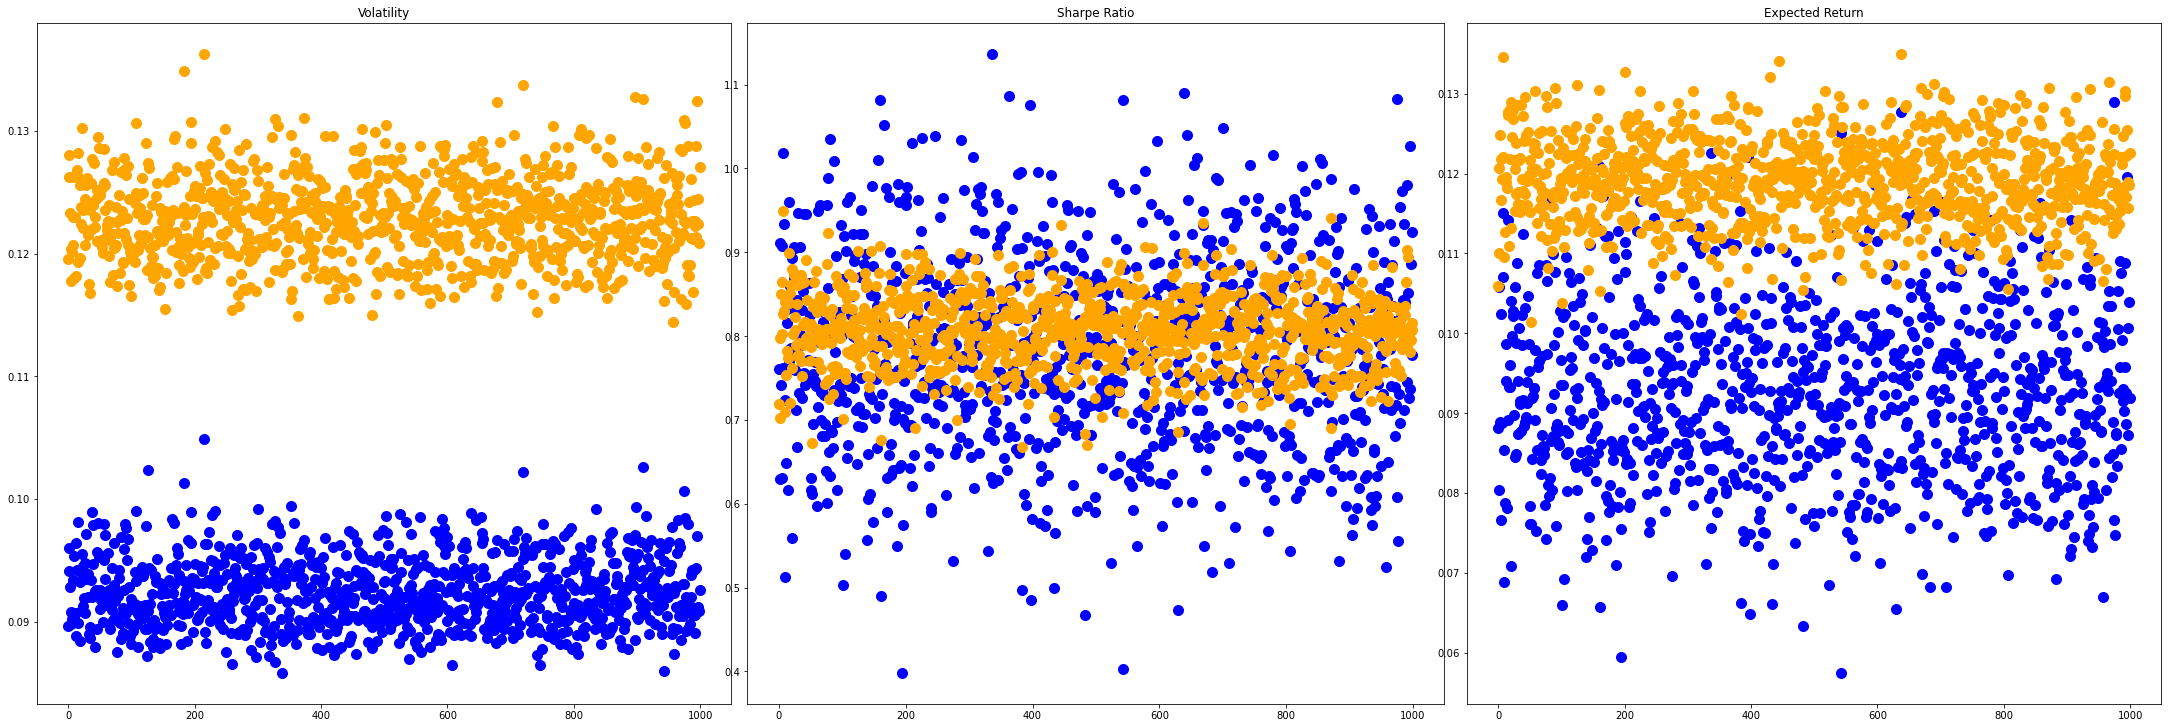

In [93]:
fig, axes  = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), constrained_layout=True)

# Volatility graphs
plt.subplot(1, 3, 1)
plt.title("Volatility")
plt.scatter(efficient_frontiers_results.index, efficient_frontiers_results["Volatility"], color="blue", s=100);
plt.scatter(hierarchical_risk_parity_results.index, hierarchical_risk_parity_results["Volatility"], color="orange", s=100);

# Sharpe Ratio graphs
plt.subplot(1, 3, 2)
plt.title("Sharpe Ratio")
plt.scatter(efficient_frontiers_results.index, efficient_frontiers_results["Sharpe Ratio"], color="blue", s=100);
plt.scatter(hierarchical_risk_parity_results.index, hierarchical_risk_parity_results["Sharpe Ratio"], color="orange", s=100);

# Annual Expected Return graphs
plt.subplot(1, 3, 3)
plt.title("Expected Return")
plt.scatter(efficient_frontiers_results.index, efficient_frontiers_results["Expected Return"], color="blue", s=100);
plt.scatter(hierarchical_risk_parity_results.index, hierarchical_risk_parity_results["Expected Return"], color="orange", s=100);

## Comparing In-Sample Weights
Now that we have seen roughly how well a variety of models trained a different stocks perform, it's important to find out how well diversified each portfolio is.
We will start by comparing the distribution of stocks across efficient frontier and hierarchical risk parity portfolios and then move to gauging the hierarchical dendrogram (which shows how things were grouped together).

We can tell that the hierarchical risk parity models are increasing diversity not just from the bar graphs (efficient frontier left, hierarchical risk parity right) and performance scatter plots (above), but from correlation matrices sustained dark black general colour.
Bright colours imply correlation, so we know that the stocks in the chosen portfolios are not highly correlated (so when one falls in price, the others are not likely to).
Therefore, the following trends make sense:
* Efficient frontiers are overall brighter/have more correlations between stocks
* Low volatility portfolios have the least correlations and so are darkest

The increased diversity is what signals that these hierarchical risk parity models should perform well out of sample (compared to others).
If we change up the number of stocks in each sample portfolio, we will see that the new hierarchical risk parity will oust the efficient frontiers by greater and greater margins.

Note that although this stays true for all models (i.e. best ones which minimise volatility and maximise sharpe ratio or annual expected returns), we will just look at those which provide lowest volatility.
This is because the graphs tend to look extremely similar...

### Overall Best Volatility

In [6]:
index_best_efficient_frontier_volatility = efficient_frontiers_results["Volatility"].argmax()
index_best_hierarchical_risk_parity_volatility = hierarchical_risk_parity_results["Volatility"].argmax()

In [7]:
efficient_frontiers_results.loc[[index_best_efficient_frontier_volatility]].style.set_caption("Best Sharpe Ratio for Efficient Frontier")
print("\n")
hierarchical_risk_parity_results.loc[[index_best_hierarchical_risk_parity_volatility]].style.set_caption("Best Sharpe Ratio for hierarchical Risk Parity")

Through looking at the relative stock weights on a chart, we can gauge how a portolio is holistically structured.
We can see that the efficient frontier sets majority of its weights to zero (i.e. does not use them) creating a small portfolio reliant on a few specific stocks.
On the other hand, the hierarchical model chooses to assign positive weights for every stingle stock (albeit some smaller than others).
This gives us some confidence that we are not completely over reliant in a single stocks performance...

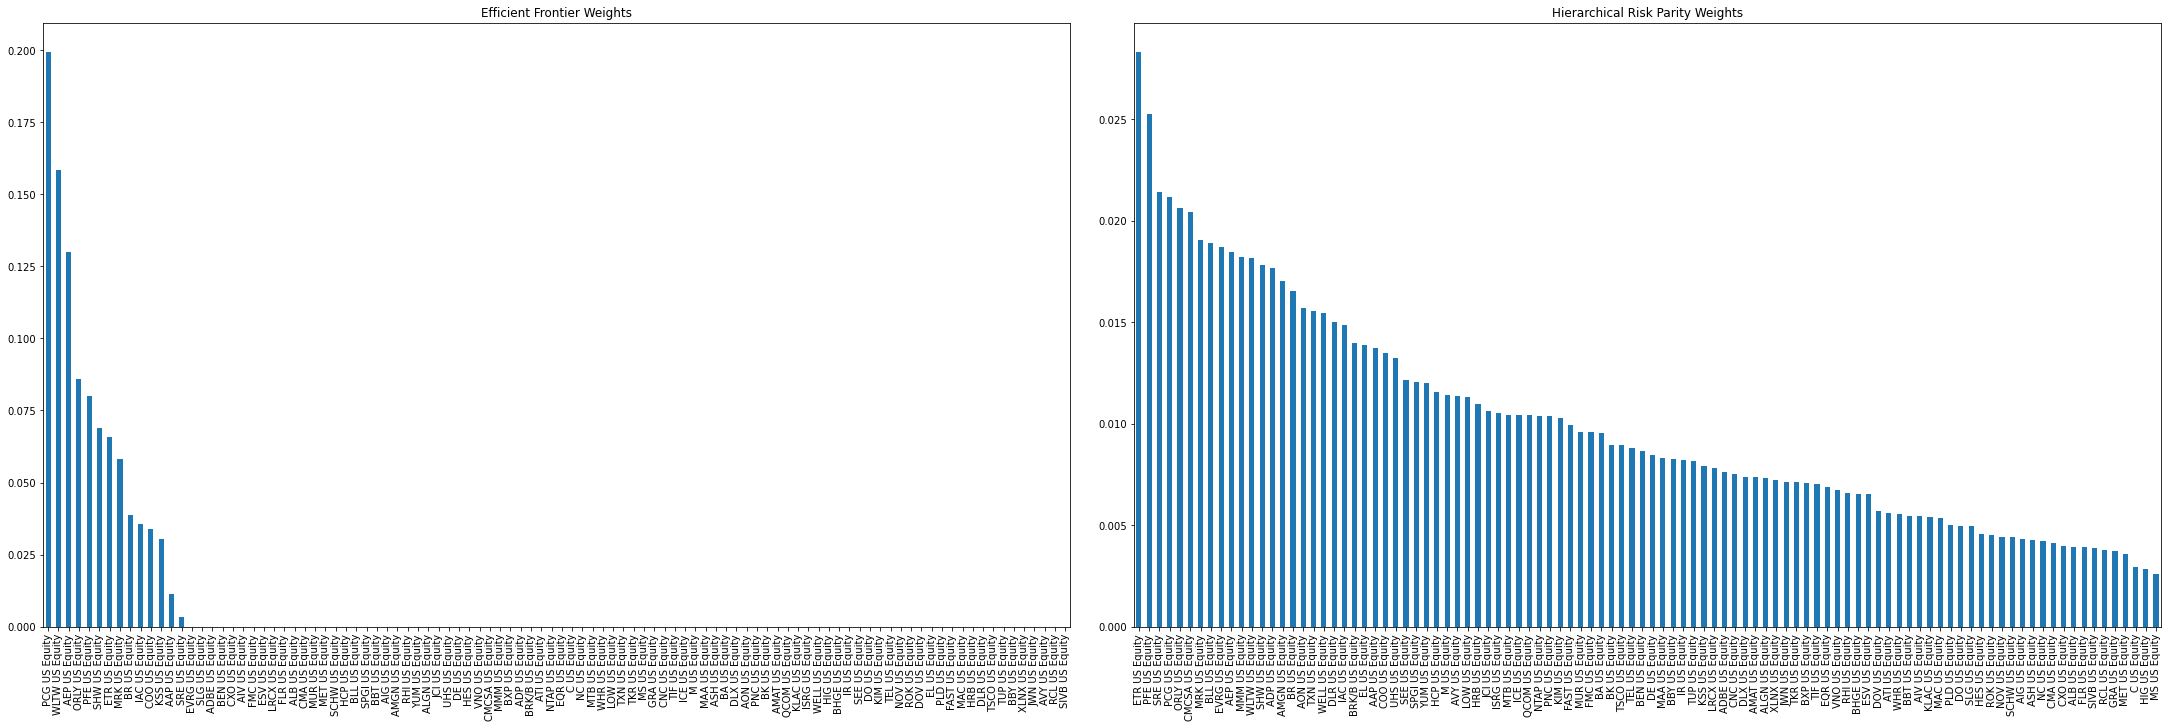

In [92]:
fig, axes  = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), constrained_layout=True)

efficient_frontiers_weights[index_best_efficient_frontier_volatility]["Weights"].sort_values(ascending=False).plot.bar(ax=axes[0], title="Efficient Frontier Weights");
hierarchical_risk_parities_weights[index_best_hierarchical_risk_parity_volatility]["Weights"].sort_values(ascending=False).plot.bar(ax=axes[1], title="Hierarchical Risk Parity Weights");

How well a portfolio does when one of its stocks price drops is greatly influenced by the covariance between different stocks.
If one stocks price rise causes anothers too, the combination are likely not a safe bet.
Hence, to asses diversity we can analyse how bright (high covariance) or dark (low covariance) our portfolios are.

The hierarchical risk parity model has assigned weights which seem far more diverse and so likely safe out of sample.

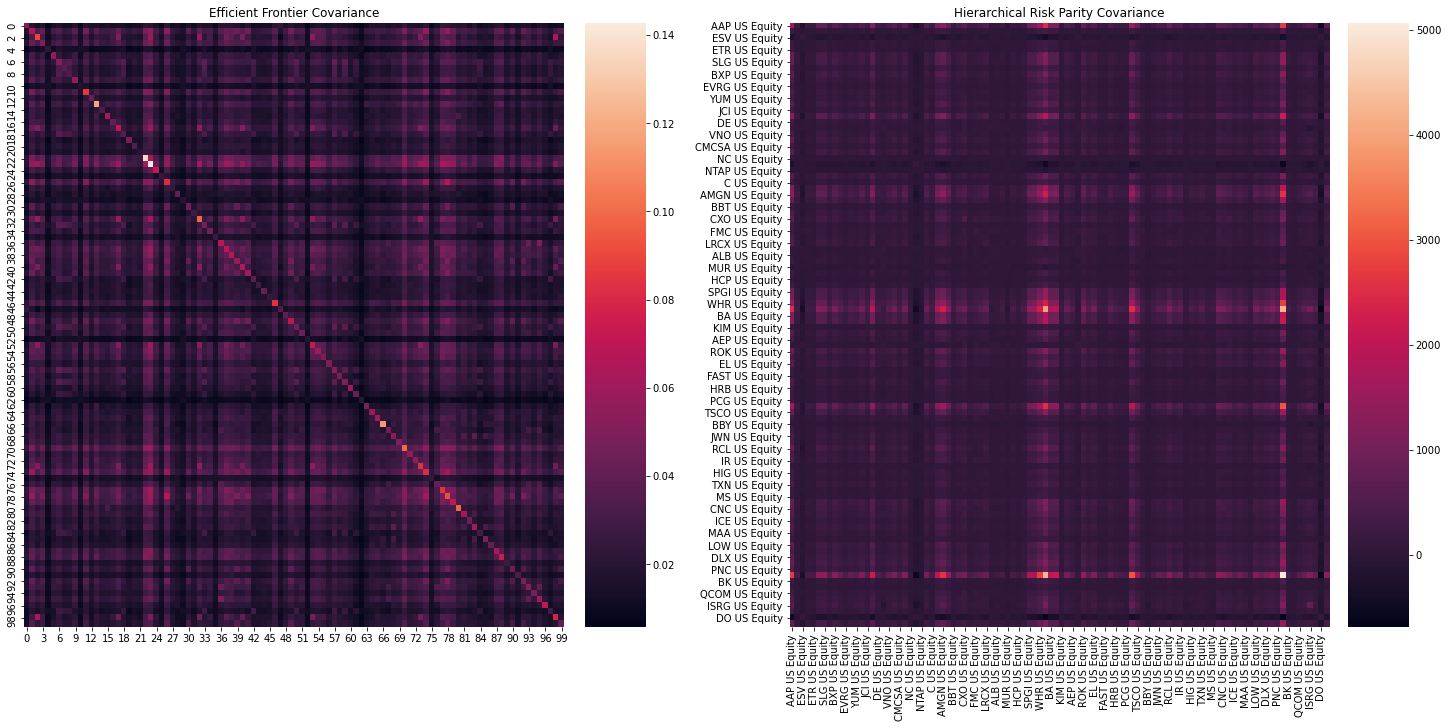

In [89]:
fig, axes  = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), constrained_layout=True)

axes[0].set_title("Efficient Frontier Covariance")
sns.heatmap(efficient_frontiers[index_best_efficient_frontier_volatility].cov_matrix, ax=axes[0]);

axes[1].set_title("Hierarchical Risk Parity Covariance")
sns.heatmap(random_portfolios[index_best_hierarchical_risk_parity_volatility].cov(), ax=axes[1]);

To see how our model has grouped the stocks together, we can take a look at a dendrogram.
A dendrogram visually depicts a hierarchy, and we can colour major groups.
We can see here that there are two major distinct groups, with several sub-categories.
This along with gemetric distance measurements allows the model to optimise with stock similarity in mind!

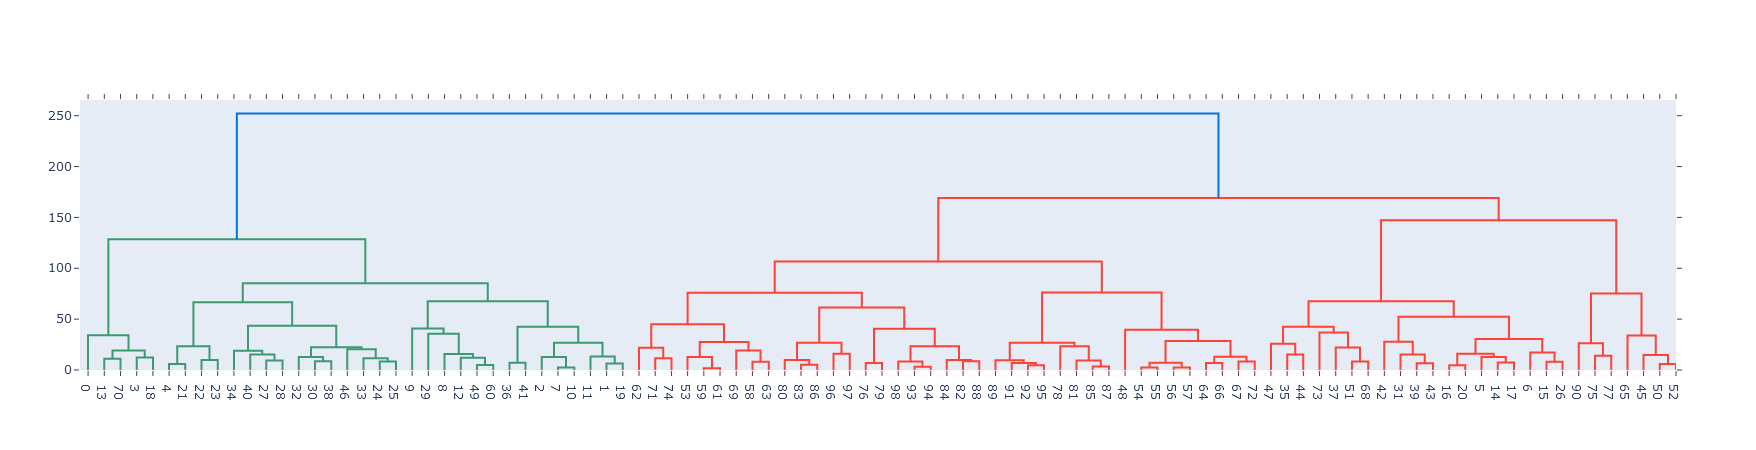

In [10]:
create_dendrogram(hierarchical_risk_parities[index_best_hierarchical_risk_parity_volatility].clusters)

## Out of Sample Tests
Although we have tested our efficient frontier and hierarchical risk parity models in-sample so far.
Since we have a large number of portfolios, all weight sets of optimised weights, we can test which method actually (on average) produces better, more reliable results.
On the following graphs we will see the performance distributions.

### Test Porfolio Performances

In [39]:
test_data = data.generate_random_portfolios(data.import_range("2010")["2015":], no_stocks=100, no_portfolios=1000)

efficient_frontiers_test_results, hierarchical_risk_parity_test_results = pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"]), pd.DataFrame(columns=["Expected Return", "Volatility", "Sharpe Ratio"])

for index, portfolio in enumerate(test_data):
    # Efficient Frontiers
    efficient_frontiers_test_results.loc[index] = portfolio_performance(
        efficient_frontiers[index].weights,
        portfolio.pct_change().dropna().mean() * 252,
        portfolio.pct_change().dropna().cov() * 252,
        verbose=False
    )

    # Hierarchical Risk Parity
    hierarchical_risk_parity_test_results.loc[index] = portfolio_performance(
        hierarchical_risk_parities[index].weights,
        portfolio.pct_change().dropna().mean() * 252,
        portfolio.pct_change().dropna().cov() * 252,
        verbose=False
    )

In [69]:
data.display_side_by_side(
    [
        efficient_frontiers_test_results.sort_values("Volatility")[:5],
        hierarchical_risk_parity_test_results.sort_values("Volatility")[:5]
    ],
    captions=["Efficient Frontier Volatility", "Hierarchical Risk Parity Volatility"]
)

print("\n\n")

data.display_side_by_side(
    [
        efficient_frontiers_test_results.sort_values("Sharpe Ratio")[:5],
        hierarchical_risk_parity_test_results.sort_values("Sharpe Ratio")[:5]
    ],
    captions=["Efficient Frontier Sharpe Ratio", "Hierarchical Risk Parity Sharpe Ratio"]
)

### Performance Visualisations
As we can see the efficient frontier are overal far less stable than the hierarchical risk parity models.
The the hierarchical risk parity porfolios consistantly fall within a slim range of values for sharpe ratio and expected returns.
This is largely true for the volatility graphs as well, although a large number of efficient frontier values end up lower.


The broad range of values for efficient frontiers raises questions about stability and safety, as a portfolio which seems to perform well in-sample may not out of sample...

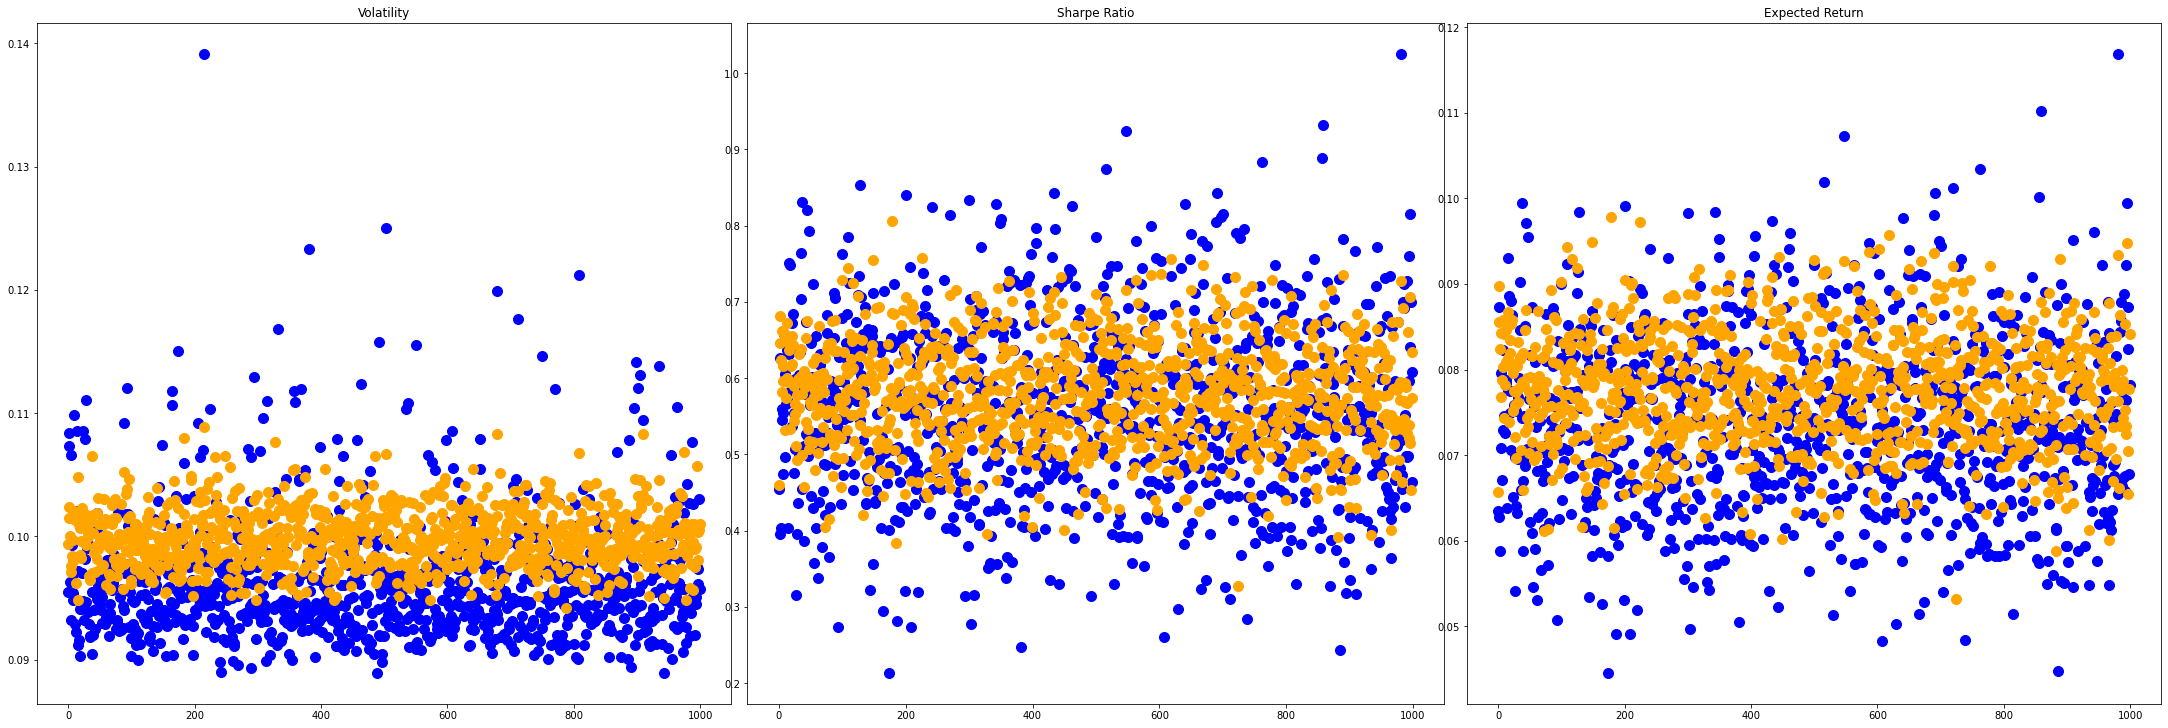

In [86]:
fig, axes  = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), constrained_layout=True)

# Volatility graphs
plt.subplot(1, 3, 1)
plt.title("Volatility")
plt.scatter(efficient_frontiers_test_results.index, efficient_frontiers_test_results["Volatility"], color="blue", s=100);
plt.scatter(hierarchical_risk_parity_test_results.index, hierarchical_risk_parity_test_results["Volatility"], color="orange", s=100);

# Sharpe Ratio graphs
plt.subplot(1, 3, 2)
plt.title("Sharpe Ratio")
plt.scatter(efficient_frontiers_test_results.index, efficient_frontiers_test_results["Sharpe Ratio"], color="blue", s=100);
plt.scatter(hierarchical_risk_parity_test_results.index, hierarchical_risk_parity_test_results["Sharpe Ratio"], color="orange", s=100);

# Annual Expected Return graphs
plt.subplot(1, 3, 3)
plt.title("Expected Return")
plt.scatter(efficient_frontiers_test_results.index, efficient_frontiers_test_results["Expected Return"], color="blue", s=100);
plt.scatter(hierarchical_risk_parity_test_results.index, hierarchical_risk_parity_test_results["Expected Return"], color="orange", s=100);